<b>Identify key aspects of a Review</b>

I solved this problem using Machine Learning with TfidfVectorizer and DecisionTreeClassifier
I created a Python Jupyter Notebook which contain the complete project includes data preprocessing and ML Model Training.

Software Requirement

Pytorch, numpy, pandas, torchvision, sklearn, scipy, matplotlib, seaborn

Installation.

You can install all the softwares saperately or just run this command with requirements.txt given in the zip

pip install -r requirements.txt

Finally create a folder name "save" in the same place where put the notepad file for saving the model temporarily

In [311]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import operator
import json
from xgboost import XGBClassifier
import re, string
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale, PolynomialFeatures
from sklearn.datasets import load_boston
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from pandas.plotting import scatter_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from datetime import datetime
from scipy import stats
from sklearn.svm import SVC
import torch.utils.data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from torch.autograd import Variable
from bs4 import BeautifulSoup
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
#import cufflinks as cf

import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
pd.set_option('display.max_columns', 500)

#init_notebook_mode(connected=True)
#cf.go_offline()

[nltk_data] Downloading package punkt to /home/koushik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [312]:
train_csv = pd.read_csv("Dataset/train.csv", keep_default_na=False)
test_csv = pd.read_csv("Dataset/test.csv", keep_default_na=False)

data = {}
labels = {}

In [313]:
test_csv.shape

(2553, 2)

In [314]:
train_csv.shape

(5959, 3)

In [315]:
stemmer = PorterStemmer()

def beautifyAllText(x):
    if x != "":
        text = BeautifulSoup(x, "html.parser").get_text() # Remove HTML tags
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
        words = text.split() # Split string into words
        words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
        words = [PorterStemmer().stem(w) for w in words] # stem
        return " ".join(words)
    return x

def preprocess_data(dataset):
    #dataset.sort_values("Review Text", inplace = True) 
    #dataset.drop_duplicates(subset ="Review Text", keep=False,inplace=False)
    #dataset = dataset.reset_index(drop=True)
    dataset['Review Text'] = dataset["Review Title"].map(str) + " " + dataset['Review Text']
    dataset['Review Text'] = dataset["Review Text"].apply(beautifyAllText)
    #dataset = dataset.drop(['Review Title'],axis=1)
    return dataset

In [316]:
test_csv.drop_duplicates(subset ="Review Text", keep=False,inplace=False)
test_csv = test_csv.reset_index(drop=True)

train = preprocess_data(train_csv.copy())
test = preprocess_data(test_csv.copy())

train_val = train[0:1000]
train_val.drop_duplicates(subset ="Review Text", keep=False,inplace=False)

train_X = train["Review Text"]
train_y = train["topic"]
test_X = test["Review Text"]

lbl = LabelEncoder() 
lbl.fit(list(train_y.values))

train_y_label = lbl.transform(train_y.values)
train["labels"] = train_y_label

train_val["topic"] = lbl.transform(train_val["topic"].values)

binary_label = pd.get_dummies(train_y)

#train_X, test_X, train_y, test_y = train_test_split(train["Review Text"], train["topic"], random_state=33)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))
#s = " ".join(train["Review Text"][0:10])
print(test.head())

IMDb reviews (combined): train = 5959, test = 2553
                                         Review Text  \
0  bad tast use chia seed protein shake tast like...   
1  bad tast use chia seed protein shake tast like...   
2                            chang result wast money   
3  good vegan choic poor non vegan choic use book...   
4  good vegan choic poor non vegan choic use book...   

                               Review Title  
0                                  Bad tast  
1                                  Bad tast  
2                    No change. No results.  
3  Good Vegan Choice, Poor Non Vegan Choice  
4  Good Vegan Choice, Poor Non Vegan Choice  


In [317]:
train_X[0]

'useless noth help lost even work eat healthi curb appetit anyth'

In [318]:
lens = train_X.str.len()
lens.mean(), lens.std(), lens.max()

(168.12384628293339, 161.0621470324028, 1665)

In [319]:
train.head()

,Review Text,Review Title,topic,labels
0,useless noth help lost even work eat healthi c...,Useless,Shipment and delivery,15
1,useless noth help lost even work eat healthi c...,Useless,Not Effective,11
2,trash buy bag waist time bought bag immedi ope...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service,4
3,recommend gave allerg reaction face,Do not recommend,Allergic,0
4,tackl big mess compar name brand wipe famili 5...,Can't tackle big messes,Texture,17


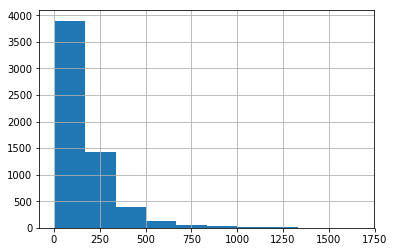

In [320]:
lens.hist();

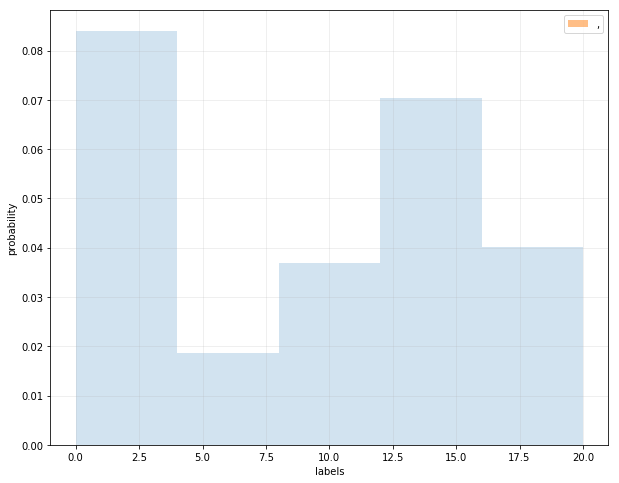

In [321]:
plt.figure(figsize=(10, 8))
plt.hist(train_y_label, 5, alpha=0.2, density=True)
plt.hist(
    [train.loc[train['Review Text'].apply(lambda p: ',' in p), 'labels'],
     train.loc[train['Review Text'].apply(lambda p: '.' in p), 'labels'],
     train.loc[train['Review Text'].apply(lambda p: '!' in p), 'labels'],
     train.loc[train['Review Text'].apply(lambda p: '?' in p), 'labels']],
    5, alpha=0.5, density=True,
    label=[',', '.', '!', '?'])

plt.xlabel('labels')
plt.ylabel('probability')
plt.grid(alpha=0.25)
plt.legend(loc='upper right')

In [322]:
train.groupby('topic').count()

,Review Text,Review Title,labels
topic,,,
Allergic,567,567,567
Bad Taste/Flavor,1194,1194,1194
Color and texture,234,234,234
Customer Issues,8,8,8
Customer Service,239,239,239
Didn't Like,31,31,31
Expiry,136,136,136
False Advertisement,37,37,37
Hard to Chew,6,6,6


In [323]:
#train.groupby('topic').count()['Review Title'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8, title='Bar chart of Department Name', xTitle='Department Name')

In [324]:
#train_X.fillna("unknown", inplace=True)
#test_X.fillna("unknown", inplace=True)
#train_val["Review Text"].fillna("unknown", inplace=True)

In [325]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [326]:
n = train_X.shape[0]

vec = TfidfVectorizer(ngram_range=(1,5), smooth_idf=True, use_idf=True, sublinear_tf=1, max_features=6300, 
                      strip_accents='unicode' )    
"""
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
"""

vec = vec.fit(pd.concat([train_X, test_X], axis=0))

trn_term_doc = vec.transform(train_X)
val_term_doc = vec.transform(train_val["Review Text"])
test_term_doc = vec.transform(test_X)

print(len(vec.get_feature_names()))

6300


In [327]:
print(trn_term_doc.shape)
print(type(trn_term_doc))
print(trn_term_doc.toarray())

(5959, 6300)
<class 'scipy.sparse.csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [328]:
#print(trn_term_doc)

In [329]:
trn_term_doc, test_term_doc, val_term_doc

(<5959x6300 sparse matrix of type '<class 'numpy.float64'>'
 	with 168774 stored elements in Compressed Sparse Row format>,
 <2553x6300 sparse matrix of type '<class 'numpy.float64'>'
 	with 73446 stored elements in Compressed Sparse Row format>,
 <1000x6300 sparse matrix of type '<class 'numpy.float64'>'
 	with 27290 stored elements in Compressed Sparse Row format>)

In [330]:
x = trn_term_doc
test_term = test_term_doc
X_val = val_term_doc

#X_train, X_val, y_train, y_val = train_test_split(x, binary_label, random_state=0)

In [331]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [332]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [333]:
print(binary_label.head())

   Allergic  Bad Taste/Flavor  Color and texture  Customer Issues  \
0         0                 0                  0                0   
1         0                 0                  0                0   
2         0                 0                  0                0   
3         1                 0                  0                0   
4         0                 0                  0                0   

   Customer Service  Didn't Like  Expiry  False Advertisement  Hard to Chew  \
0                 0            0       0                    0             0   
1                 0            0       0                    0             0   
2                 1            0       0                    0             0   
3                 0            0       0                    0             0   
4                 0            0       0                    0             0   

   Inferior to competitors  Ingredients  Not Effective  Packaging  Pricing  \
0                        0      

In [334]:
label_cols = binary_label.columns;
print(label_cols)

Index(['Allergic', 'Bad Taste/Flavor', 'Color and texture', 'Customer Issues',
       'Customer Service', 'Didn't Like', 'Expiry', 'False Advertisement',
       'Hard to Chew', 'Inferior to competitors', 'Ingredients',
       'Not Effective', 'Packaging', 'Pricing', 'Quality/Contaminated',
       'Shipment and delivery', 'Smells Bad', 'Texture', 'Too Sweet',
       'Too big to swallow', 'Wrong Product received'],
      dtype='object')


In [335]:
final_preds = np.zeros((len(test_X), len(label_cols)))
#print(preds.shape)

model = LogisticRegressionCV()
#model = SVC(class_weight=None)
#model = MultinomialNB()
#model = DecisionTreeClassifier(random_state=0)

model = model.fit(x, list(train_y_label))
train_score = model.score(x, train_y_label)
print(train_score)

preds = model.predict(X_val)
test_score = model.score(X_val, train_val["topic"])
print(test_score)


final_preds = model.predict(test_term)
"""
for i, col in enumerate(label_cols):
    print('fit', col)
    m,r = get_mdl(binary_label[col])
    final_preds[:,i] = m.predict_proba(test_term.multiply(r))[:,1]

"""
print(final_preds)

0.7033059238127203
0.709
[14 14 11 ...  0 14  4]


In [336]:
"""
final_preds = np.zeros((len(test_X), len(label_cols)))
print(final_preds.shape)

for i, col in enumerate(label_cols):
    print('fit', col)
    m,r = get_mdl(binary_label[col])
    final_preds[:,i] = m.predict_proba(test_term.multiply(r))[:,1]

#print(preds)

output = []
for row in final_preds:
    output.append(np.argmax(row))
print(output)
"""

"\nfinal_preds = np.zeros((len(test_X), len(label_cols)))\nprint(final_preds.shape)\n\nfor i, col in enumerate(label_cols):\n    print('fit', col)\n    m,r = get_mdl(binary_label[col])\n    final_preds[:,i] = m.predict_proba(test_term.multiply(r))[:,1]\n\n#print(preds)\n\noutput = []\nfor row in final_preds:\n    output.append(np.argmax(row))\nprint(output)\n"

In [337]:
predictions = pd.DataFrame(test_csv["Review Text"].values, columns = ["Review Text"])
predictions["Review Title"] = test_csv["Review Title"].values
predictions["topic"] = pd.Series(lbl.inverse_transform(final_preds))
display(predictions.head())
predictions.to_csv('submission_10.csv', index=False)

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [338]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
